# Long-tail Scailing

- 영화 관점(movie_info_df): 1명, 3명 미만의 영화
- 유저 관점(user_info_df): 소수 리뷰 남긴 사람 비율

### 0. Data 로드

In [22]:
import pandas as pd
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

'C:\\Users\\user\\Jupyter_project\\keejun\\NLP_GNN_STUDY\\Research'

In [24]:
# path = './../../data/amazon/'
path = './../../data/rotten_tomato/'
os.listdir(path)

['.ipynb_checkpoints',
 'emotion_analysis_data',
 'final_rating(sentiment,emotion).csv',
 'graph',
 'model.pth',
 'model_new.pth',
 'model_rotten.pth',
 'model_save',
 'movie1_neg.txt',
 'movie1_pos.txt',
 'movie2_neg.txt',
 'movie2_pos.txt',
 'movie3_neg.txt',
 'movie3_pos.txt',
 'rotten_movie_table.csv',
 'rotten_rating(review_100_user).csv',
 'rotten_rating(review_20_user).csv',
 'rotten_rating_review_emotion_table.csv',
 'rotten_rating_review_emotion_table.xlsx',
 'rotten_rating_review_sentiment_table.csv',
 'rotten_rating_review_sentiment_table.xlsx',
 'rotten_rating_review_table.csv',
 'rotten_review_scaled_clean.csv',
 'rotten_review_scaled_label(pos,neu,neg).csv',
 'rotten_review_scaled_label.csv',
 'rotten_review_scaled_new.csv',
 'rotten_tomatoes_critic_reviews.csv',
 'rotten_tomatoes_movies.csv',
 'rotten_user_table.csv',
 'sentiment_analysis_data',
 'testset.csv',
 'trainset.csv']

In [25]:
# ratings_df = pd.read_csv(os.path.join(path, 'amazon(review_50_user).csv'), encoding='utf-8')
ratings_df = pd.read_csv(os.path.join(path, 'rotten_rating(review_20_user).csv'), encoding='utf-8')
# ratings_df.rename(columns={'review_score':'rating'}, inplace=True)

print(ratings_df.shape)

(721094, 8)


In [26]:
ratings_df.head()

,user_id,movie_id,review_score,sentiment,emotion,review_date,origin_rating,rating
0,7242,0,0.25,0,2,2010-02-10,1.625,1.5
1,1046,0,0.70,3,2,2010-02-10,3.650,3.5
2,4895,0,0.70,4,2,2010-02-10,3.650,3.5
3,4517,0,0.60,1,2,2010-02-10,3.200,3.0
4,6226,0,0.80,4,2,2010-02-10,4.100,4.0


In [27]:
# ratings_df['rating'] = ratings_df['review_score']*4 + 1

In [28]:
ratings_df.describe()

,user_id,movie_id,review_score,sentiment,emotion,origin_rating,rating
count,721094.000000,721094.000000,721094.000000,721094.00000,721094.000000,721094.000000,721094.000000
mean,5226.375464,9651.300891,0.636735,2.33972,2.004851,3.365307,3.146860
std,2732.873872,4901.324694,0.210749,1.26894,1.092056,0.948372,0.997771
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.500000,0.500000
25%,2893.000000,5444.000000,0.500000,1.00000,2.000000,2.750000,2.500000
50%,5444.000000,10297.000000,0.625000,3.00000,2.000000,3.312500,3.000000
75%,7653.000000,13690.000000,0.800000,3.00000,2.000000,4.100000,4.000000
max,9815.000000,17711.000000,1.000000,4.00000,5.000000,5.000000,5.000000


### 0. 전체 현황

array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'movie_id'}>],
       [<AxesSubplot:title={'center':'rating'}>, <AxesSubplot:>]],
      dtype=object)

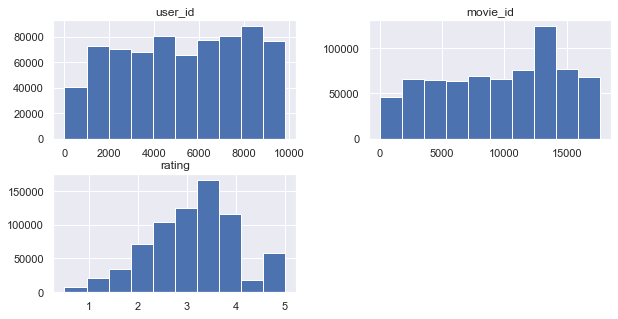

In [29]:
ratings_df[['user_id','movie_id','rating']].hist()

### 1. User 관점
- 유저 관점(user_info_df): 소수 리뷰 남긴 사람 비율

In [30]:
group = ratings_df.groupby('user_id')
group_user_id = group['movie_id'].count()

In [31]:
len(group_user_id)

2994

In [32]:
group_user_id.sort_values(ascending=False)[:10]

user_id
2600    6486
8148    6356
3265    5300
2495    5212
3926    4548
5446    4219
5716    3759
7603    3552
7917    3481
1738    3440
Name: movie_id, dtype: int64

- 평점 갯수

In [33]:
def cal_rate(num, total, limit, condition):
    if condition == 'low':
        print(f"{limit}개 미만: {sum(num < limit)}, {round((sum(num < limit)/total),2)*100}%")
        
    if condition == 'high':
        print(f"{limit}개 이상: {sum(num >= limit)}, {round((sum(num >= limit)/total),2)*100}%")

In [34]:
num = group_user_id.sort_values()
total = len(group_user_id)

condition = 'low'
cal_rate(num, total, 3, condition)
cal_rate(num, total, 5, condition)
cal_rate(num, total, 10, condition)

3개 미만: 0, 0.0%
5개 미만: 0, 0.0%
10개 미만: 0, 0.0%


In [35]:
condition = 'high'
cal_rate(num, total, 20, condition)
cal_rate(num, total, 500, condition)

20개 이상: 2994, 100.0%
500개 이상: 345, 12.0%


In [36]:
group_user_id.sort_values()

user_id
1725      20
7188      20
7921      20
4134      20
7911      20
        ... 
3926    4548
2495    5212
3265    5300
8148    6356
2600    6486
Name: movie_id, Length: 2994, dtype: int64

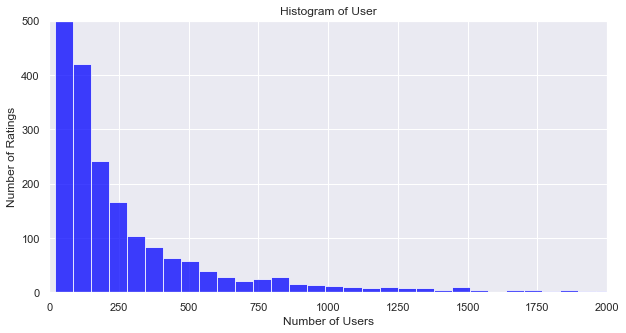

In [37]:
fig = plt.figure(figsize = (10,5))
plt.hist(group_user_id.sort_values(), 
                    bins=100, 
                    facecolor='blue', 
                    alpha=0.75)
plt.xlabel('Number of Users')
plt.ylabel('Number of Ratings')
# plt.yscale('log')
plt.title('Histogram of User')
plt.axis([0, 2000, 0, 500])
plt.show()

C:\Users\user\anaconda3\envs\graph\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


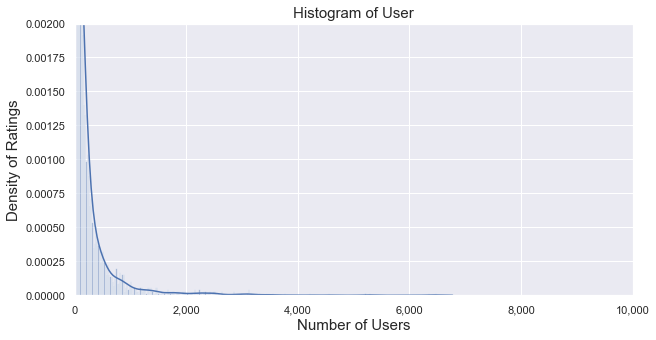

In [38]:
import seaborn as sns
import matplotlib

p = sns.set(font_scale=1, rc={'figure.figsize':(10, 5)})
fig, ax = plt.subplots()
p = sns.distplot(group_user_id.sort_values(), ax=ax, bins=300)
p.set_title('Histogram of User', fontsize = 15)
p.set_xlabel('Number of Users', fontsize = 15)
p.set_ylabel('Density of Ratings', fontsize = 15)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(0, 10000)
ax.set_ylim(0, 0.002)
plt.show()

### 2. Movie 관점
- 영화 관점(movie_info_df): 1명, 3명 미만의 영화

In [17]:
group = ratings_df.groupby('movie_id')
group_movie_id = group['user_id'].count()

In [31]:
group_movie_id.sort_values(ascending=False)[:20]

movie_id
13801    670
13522    632
13800    628
13690    622
12311    602
13799    598
12665    594
13184    590
13389    548
13781    538
14028    532
13692    526
13691    524
14033    490
13723    480
12644    478
13673    476
13031    462
12674    462
13788    460
Name: user_id, dtype: int64

In [32]:
group_movie_id.sort_values()[:20]

movie_id
4861     1
11516    1
4388     1
7861     1
3439     1
15879    1
927      1
9284     1
11440    1
11436    1
4410     1
7839     1
9309     1
7822     1
7815     1
5502     1
4452     1
11344    1
3765     1
11341    1
Name: user_id, dtype: int64

In [33]:
len(group_movie_id)

17614

In [34]:
num = group_movie_id.sort_values()
total = len(group_movie_id)

condition = 'low'
cal_rate(num, total, 3, condition)
cal_rate(num, total, 5, condition)

3개 미만: 993, 6.0%
5개 미만: 2892, 16.0%


In [35]:
condition = 'high'
cal_rate(num, total, 20, condition)
cal_rate(num, total, 500, condition)

20개 이상: 8110, 46.0%
500개 이상: 13, 0.0%


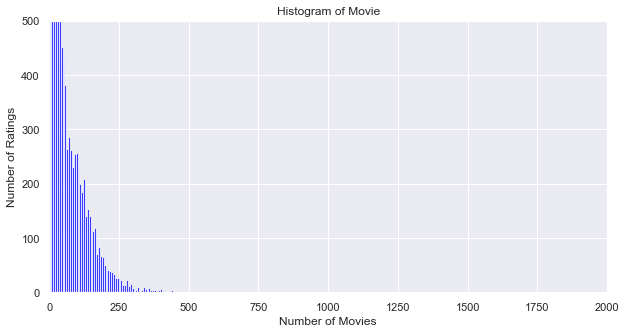

In [36]:
fig = plt.figure(figsize = (10,5))
plt.hist(group_movie_id.sort_values(), 
                    bins=100, 
                    facecolor='blue', 
                    alpha=0.75)
plt.xlabel('Number of Movies')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Movie')
plt.axis([0, 2000, 0, 500])
plt.show()

C:\Users\user\anaconda3\envs\graph\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


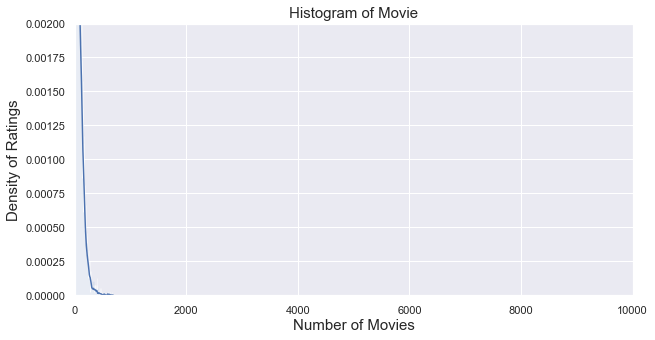

In [43]:
import seaborn as sns

p = sns.set(font_scale=1, rc={'figure.figsize':(10, 5)})
fig, ax = plt.subplots()
p = sns.distplot(group_movie_id.sort_values(), ax=ax, bins=300)
p.set_title('Histogram of Movie', fontsize = 15)
p.set_xlabel('Number of Movies', fontsize = 15)
p.set_ylabel('Density of Ratings', fontsize = 15)
ax.set_xlim(0, 10000)
ax.set_ylim(0, 0.002)
plt.show()

### 3. Rating 관점
- 1~5점 평점 비율

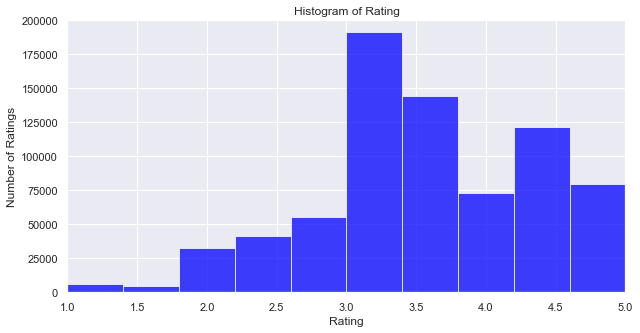

In [38]:
fig = plt.figure(figsize = (10,5))
plt.hist(ratings_df['rating'], 
                    bins=10, 
                    facecolor='blue', 
                    alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Rating')
plt.axis([1, 5, 0, 200000])
plt.show()

In [24]:
bins = np.linspace(1, 5, 5)

In [25]:
bins

array([1., 2., 3., 4., 5.])

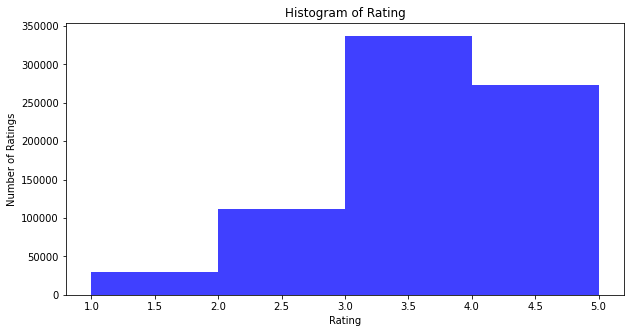

In [26]:
fig = plt.figure(figsize = (10,5))
plt.hist(ratings_df['rating'], 
                    bins=bins, 
                    facecolor='blue', 
                    alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Rating')
# plt.axis([1, 5, 0, 200000])
plt.show()

In [27]:
ratings_df['rating'].describe()

count    751129.000000
mean          3.549336
std           0.843082
min           1.000000
25%           3.000000
50%           3.500000
75%           4.200000
max           5.000000
Name: rating, dtype: float64

In [28]:
def cal_rate_2(num, total, low, high):        
    print(f"{low}이상 ~ {high}미만: {sum((num >= low) & (num < high))}, {round(sum((num >= low) & (num < high))/total,2)*100}%")

In [29]:
num = ratings_df['rating'].sort_values()
total = len(ratings_df['rating'])

In [30]:
total

751129

In [31]:
cal_rate_2(num, total, 1, 2)
cal_rate_2(num, total, 2, 3)
cal_rate_2(num, total, 3, 4)
cal_rate_2(num, total, 4, 5)

1이상 ~ 2미만: 29336, 4.0%
2이상 ~ 3미만: 111623, 15.0%
3이상 ~ 4미만: 337170, 45.0%
4이상 ~ 5미만: 212717, 28.000000000000004%


In [32]:
sum(num == 5)

60283

In [33]:
(sum(num == 5)/total) * 100

8.025652051778057

In [34]:
condition = 'low'
cal_rate(num, total, 3, condition)
cal_rate(num, total, 5, condition)

3개 미만: 140959, 19.0%
5개 미만: 690846, 92.0%


### 4. User 관점(상위 10%)

In [38]:
group = ratings_df.groupby('user_id')
group_user_id = group['movie_id'].count()

In [47]:
sample_num = int(len(group_user_id) * 0.1)
print(f"상위 10% 인원수: {sample_num}")

상위 10% 인원수: 979


In [45]:
group_user_id.sort_values(ascending=False)[:10]

user_id
2600    6486
8148    6356
3265    5300
2495    5212
3926    4548
5446    4219
5716    3759
7603    3552
7917    3481
1738    3440
Name: movie_id, dtype: int64

In [73]:
sample = group_user_id.sort_values(ascending=False)[:sample_num]
total = len(group_user_id)

In [74]:
len(sample)

979

### 5. User 관점(리뷰 100개 이상 남긴)

In [201]:
group = ratings_df.groupby('user_id')
group_user_id = group['movie_id'].count()

In [202]:
sample_num = int(len(group_user_id) * 0.1)
print(f"상위 10% 인원수: {sample_num}")

상위 10% 인원수: 979


In [203]:
def cal_rate(num, total, limit, condition):
    if condition == 'low':
        print(f"{limit}개 미만: {sum(num < limit)}, {round((sum(num < limit)/total),2)*100}%")
        
    if condition == 'high':
        print(f"{limit}개 이상: {sum(num >= limit)}, {round((sum(num > limit)/total),2)*100}%")

In [206]:
num = group_user_id.sort_values()
total = len(group_user_id)

condition = 'high'
cal_rate(num, total, 100, condition)
cal_rate(num, total, 500, condition)

100개 이상: 1343, 14.000000000000002%
500개 이상: 345, 4.0%
